In [1]:
# set working directory to project root
import os
os.chdir("..")
# imports
from scripts.preprocess import DataHandler
import torch
from torch.utils.data import TensorDataset, DataLoader
from scripts.multilayer_perceptrons import BaselineMLP, DeepFeatureMLP, CompactBatchnormMLP
from torch import nn
import matplotlib.pyplot as plt

#### Preprocessing data:

In [2]:
# read in data
data_handler = DataHandler()
data_handler.load_data_into_class(file_path="data/project_adult.csv")

# split into train and test
X_train, X_test, y_train, y_test = data_handler.split_data(target_column="income", filepath="data/project_adult.csv" ,test_size=0.2)

# preprocess the data
X_train_processed = data_handler.preprocess_set(X_train, train_or_test="train").to_numpy()
X_test_processed = data_handler.preprocess_set(X_test, train_or_test="test").to_numpy()
label_map = {"<=50K": 0, ">50K": 1}
y_train = y_train.map(label_map).to_numpy()
y_test = y_test.map(label_map).to_numpy()

# convert to tensors and build train data set
X_train_processed = torch.from_numpy(X_train_processed).float()
X_test_processed = torch.from_numpy(X_test_processed).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()
train_dataset = TensorDataset(X_train_processed, y_train)

# set seed, set batch size, and initializes dataloader
torch.manual_seed(1)
batch_size = 2
train_dataloader_baseline_mlp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#### Training Baseline MLP:


Epoch [1/45] - Loss: 0.3357, Accuracy: 0.8446
Epoch [2/45] - Loss: 0.3221, Accuracy: 0.8538
Epoch [3/45] - Loss: 0.3190, Accuracy: 0.8529
Epoch [4/45] - Loss: 0.3177, Accuracy: 0.8538
Epoch [5/45] - Loss: 0.3174, Accuracy: 0.8566
Epoch [6/45] - Loss: 0.3157, Accuracy: 0.8543
Epoch [7/45] - Loss: 0.3157, Accuracy: 0.8565
Epoch [8/45] - Loss: 0.3142, Accuracy: 0.8583
Epoch [9/45] - Loss: 0.3148, Accuracy: 0.8563
Epoch [10/45] - Loss: 0.3148, Accuracy: 0.8558
Epoch [11/45] - Loss: 0.3125, Accuracy: 0.8562
Epoch [12/45] - Loss: 0.3141, Accuracy: 0.8577
Epoch [13/45] - Loss: 0.3143, Accuracy: 0.8568
Epoch [14/45] - Loss: 0.3117, Accuracy: 0.8592
Epoch [15/45] - Loss: 0.3112, Accuracy: 0.8582
Epoch [16/45] - Loss: 0.3104, Accuracy: 0.8592
Epoch [17/45] - Loss: 0.3125, Accuracy: 0.8580
Epoch [18/45] - Loss: 0.3109, Accuracy: 0.8591
Epoch [19/45] - Loss: 0.3121, Accuracy: 0.8576
Epoch [20/45] - Loss: 0.3116, Accuracy: 0.8589
Epoch [21/45] - Loss: 0.3106, Accuracy: 0.8587
Epoch [22/45] - Loss: 

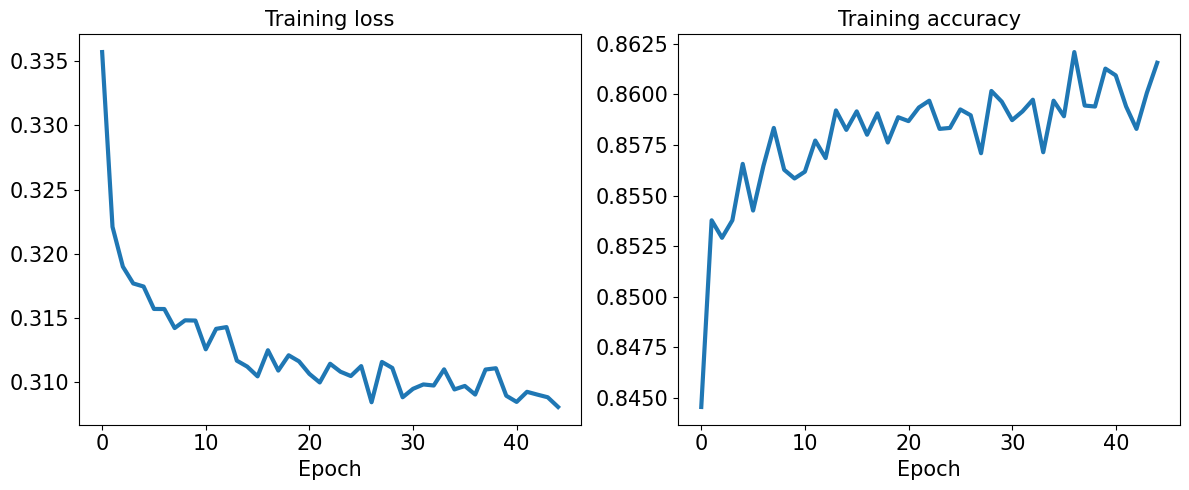

In [3]:
# initialize baseline MLP with 64 nodes in the first hidden layer and 32 in the second hidden layer
baseline_mlp = BaselineMLP(input_size=X_train_processed.shape[1], output_size=2)

# initialize loss, learning rate, and optimizer for training loop, and setting baseline mlp to train mode some dropout works
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_mlp.parameters(), lr=learning_rate, weight_decay=1e-4)
baseline_mlp.train()

# build and execute training loop
num_epochs = 45
loss_history = [0] * num_epochs
accuracy_history = [0] * num_epochs

for epoch in range(num_epochs):
    running_loss, running_correct, total = 0.0, 0, 0

    # load data
    for x_batch, y_batch in train_dataloader_baseline_mlp:
        pred = baseline_mlp(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # compute running loss
        running_loss += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().item()
        running_correct += is_correct
        total += y_batch.size(0)

    # store loss history
    loss_history[epoch] = running_loss / total
    accuracy_history[epoch] = running_correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss_history[epoch]:.4f}, "f"Accuracy: {accuracy_history[epoch]:.4f}")

# plot results
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

#### Evaluate performance of BaselineMLP:

In [5]:
# get predictions on the test set
predictions_test = baseline_mlp(X_test_processed)

# evaluate predictions
correct = (torch.argmax(predictions_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f"Test Accuracy of our BaselineMLP: {accuracy:.4f}")

Test Accuracy of our BaselineMLP: 0.8480


#### Training Deep Feature MLP: